In [1]:
import xarray as xr
import metpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load  dataset
ds = xr.open_dataset('./era5_exercise.nc')

In [3]:
# Dump netcdf information
ds

<xarray.Dataset>
Dimensions:    (longitude: 491, latitude: 451, time: 120)
Coordinates:
  * longitude  (longitude) float32 -22.0 -21.9 -21.8 -21.7 ... 26.8 26.9 27.0
  * latitude   (latitude) float32 72.0 71.9 71.8 71.7 ... 27.3 27.2 27.1 27.0
  * time       (time) datetime64[ns] 2013-01-01 2013-02-01 ... 2022-12-01
Data variables:
    ro         (time, latitude, longitude) float32 ...
    e          (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-01 10:57:21 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [4]:
# Parse full dataset
data_parsed = ds.metpy.parse_cf()
data_parsed

<xarray.Dataset>
Dimensions:    (longitude: 491, latitude: 451, time: 120)
Coordinates:
  * longitude  (longitude) float32 -22.0 -21.9 -21.8 -21.7 ... 26.8 26.9 27.0
  * latitude   (latitude) float32 72.0 71.9 71.8 71.7 ... 27.3 27.2 27.1 27.0
  * time       (time) datetime64[ns] 2013-01-01 2013-02-01 ... 2022-12-01
    metpy_crs  object Projection: latitude_longitude
Data variables:
    ro         (time, latitude, longitude) float32 ...
    e          (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-01 10:57:21 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [5]:
# Show CRS information
data_parsed['ro'].metpy.pyproj_crs

<Geographic 2D CRS: {"$schema": "https://proj.org/schemas/v0.2/projjso ...>
Name: undefined
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

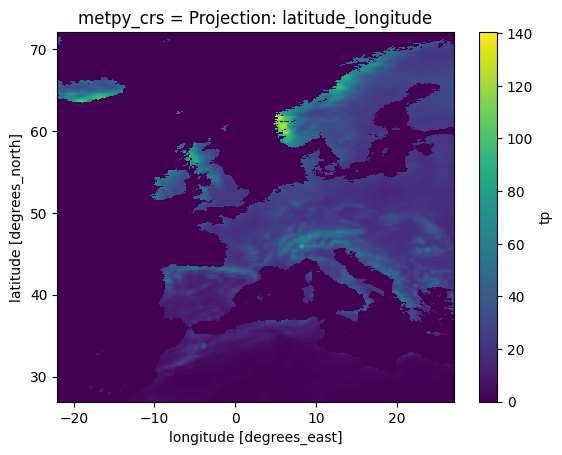

In [6]:
# Convert precip data from meter to mm
precip = data_parsed['tp']*1000
precip.sel(time='2015').sum('time').plot()


In [7]:
# Get the length of each monthly data record
month_length = ds.time.dt.days_in_month

# Plot the result
month_length

<xarray.DataArray 'days_in_month' (time: 120)>
array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 2013-02-01 ... 2022-12-01
Attributes:
    long_name:    time
    _metpy_axis:  time

In [8]:
# Calculate the weights by grouping by 'time.season'.
weights = (
    month_length.groupby("time.season") / month_length.groupby("time.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

In [9]:
# Calculate the weighted average
ds_weighted = (ds * weights).groupby("time.season").mean(dim="time")
ds_weighted

<xarray.Dataset>
Dimensions:    (longitude: 491, latitude: 451, season: 4)
Coordinates:
  * longitude  (longitude) float32 -22.0 -21.9 -21.8 -21.7 ... 26.8 26.9 27.0
  * latitude   (latitude) float32 72.0 71.9 71.8 71.7 ... 27.3 27.2 27.1 27.0
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    ro         (season, latitude, longitude) float64 nan nan ... -6.209e-11
    e          (season, latitude, longitude) float64 nan nan ... -1.011e-06
    tp         (season, latitude, longitude) float64 nan nan ... 1.2e-07

In [10]:
ds_weighted['P-E'] = (ds_weighted['tp']-ds_weighted['e'])*1000

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

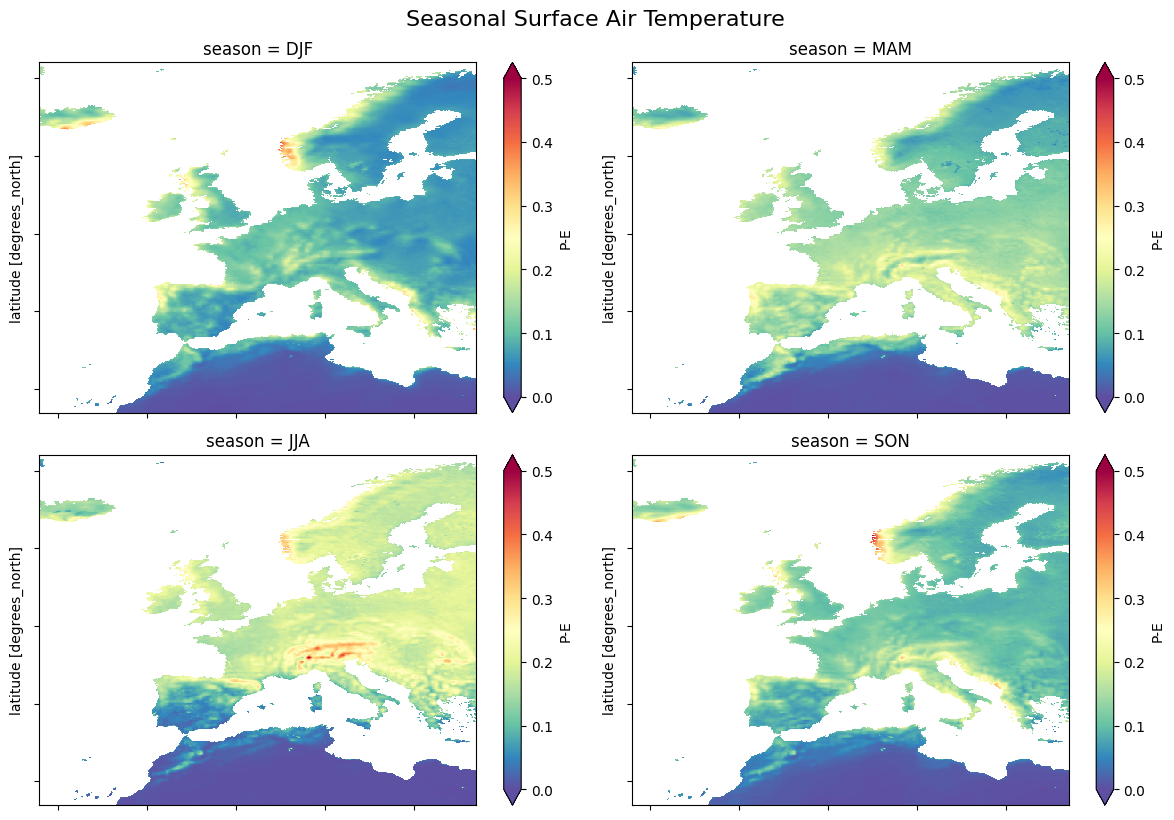

In [11]:
# Quick plot to show the results
notnull = pd.notnull(ds_weighted["ro"][0])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

ds_weighted["P-E"].sel(season='DJF').where(notnull).plot.pcolormesh(
    ax=axes[0, 0],
    cmap="Spectral_r",
    add_colorbar=True,
    extend="both",
    vmin=0.0, vmax=0.5,
)
ds_weighted["P-E"].sel(season='MAM').where(notnull).plot.pcolormesh(
    ax=axes[0, 1],
    cmap="Spectral_r",
    add_colorbar=True,
    extend="both",
    vmin=0.0, vmax=0.5,
)
ds_weighted["P-E"].sel(season='JJA').where(notnull).plot.pcolormesh(
    ax=axes[1, 0],
    cmap="Spectral_r",
    add_colorbar=True,
    extend="both",
    vmin=0.0, vmax=0.5,
)
ds_weighted["P-E"].sel(season='SON').where(notnull).plot.pcolormesh(
    ax=axes[1, 1],
    cmap="Spectral_r",
    add_colorbar=True,
    extend="both",
    vmin=0.0, vmax=0.5,
)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()

fig.suptitle("Seasonal Surface Air Temperature", fontsize=16, y=1.02)